## Overview

This notebook introduces you to Decision Trees, it consists of the following three parts:

- <a href="#Part-1---Datastructure-and-Manual-Classification">Part 1 - Datastructure and Manual Classification</a>
- <a href="#Part-2---Growing-a-Decision-Tree">Part 2 - Growing a Decision Tree</a>
- <a href="#Part-3---Full-Iris-Dataset-&amp;-Scikit-Learn">Part 3 - Full Iris Dataset &amp; Scikit-Learn</a>

### Programming Tasks
For the programming tasks you will need to replace the following comment and exception with your own code:

```python
# YOUR CODE HERE
raise NotImplementedError()
```

Most programming tasks are followed by a cell with tests (using the `assert` keyword from python). You can consult these cells while developing your implementation and for validation. Note that there may be additional, hidden tests.

**<font size="3" color="red">Note</font>**: The `@contract` decorators make sure the data types and shapes are correct for the inputs and outputs. See [here](https://andreacensi.github.io/contracts/tour.html#quick-tour) for more. If you are more comfortable working without these, you can comment out the lines starting with `@contract`. However, in that case it can get tedious to locate the exact source of a bug.

In [10]:
# DO NOT INSTALL THE LIBRARIES WHEN WORKING ON ifi-europa.uibk.ac.at

# Make sure that the required libraries are installed
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_week04.txt

In [11]:
from typing import Callable, List, Union, Optional
from copy import deepcopy

from IPython.core.display import Markdown
import numpy as np
import pandas as pd
from contracts import contract
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from decision_tree import NodeBase, print_tree, plot_surface, plot_dataset

# Counter for figures
figcount = 0

# Set the random seed for reproducing results
random_seed = 100
np.random.seed(random_seed)

<a href=#Overview> [go to top] </a>
# Part 1 - Datastructure and Manual Classification

In this part we will implement the datastructure for our decision tree. We will only use *binary splits* in our tree, which allows us to implement the tree as a *binary tree* (see Algorithm and Datastructures course for more information). 

Once we have our datastructure we will define a function for splitting a node in two *child* nodes, called the *left* and *right* node respectively. We then conclude part 1 by manually constructing a decision tree for classifying the Iris dataset shown above.

## Data

For this exercise notebook we will use the Iris dataset. This dataset consists of 3 different types of irises ('Setosa', 'Versicolour', and 'Virginica') and has 150 samples.

For the first two parts we will only use two feature dimensions of the dataset, 'petal length' and 'petal width'. In Part 3 we will use the full Iris dataset.

In [12]:
iris_2d = load_iris()
iris_2d.labels = iris_2d.target_names
iris_2d.feature_names = iris_2d.feature_names[2:4]
iris_2d.data = iris_2d.data[:, 2:4]

X = iris_2d.data
y = iris_2d.labels[iris_2d.target]

print("DATASET INFO:\n-------------")
print(f"Features:    {iris_2d.feature_names}")
print(f"Labels:      {iris_2d.labels}")
print(f"Num samples: {len(X)}")

# Convert to pandas dataframe 
df = pd.DataFrame(data=X, columns=iris_2d.feature_names)
df['label'] = pd.Series(y, dtype='category')

print("\nRandom samples from dataset:")
df.sample(frac = 1).head(10)

DATASET INFO:
-------------
Features:    ['petal length (cm)', 'petal width (cm)']
Labels:      ['setosa' 'versicolor' 'virginica']
Num samples: 150

Random samples from dataset:


,petal length (cm),petal width (cm),label
128,5.6,2.1,virginica
11,1.6,0.2,setosa
118,6.9,2.3,virginica
15,1.5,0.4,setosa
123,4.9,1.8,virginica
135,6.1,2.3,virginica
32,1.5,0.1,setosa
1,1.4,0.2,setosa
116,5.5,1.8,virginica
45,1.4,0.3,setosa


In [13]:
X.shape

(150, 2)

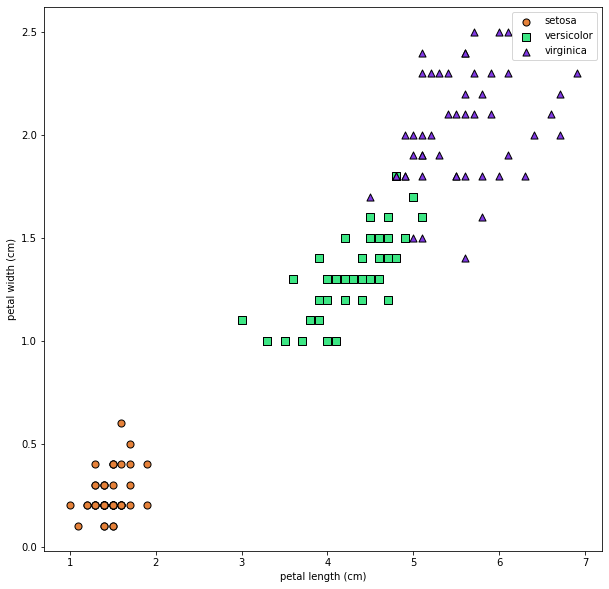

In [14]:
# we pick a color map to match that used by decision tree graphviz 
color_palette = {'setosa': '#e58139', 'versicolor': '#3de684', 'virginica': '#8139e5'}

plot_dataset(X=X, y=y, feature_names=iris_2d.feature_names, markers=[ 'o', 's', '^'], cmap=list(color_palette.values()))

## Datastructure

The whole tree is described from the *root* node down. The *root* node can contain references to two *child* nodes, the *left* and *right* child. Each *child* node can in turn have references two more *child* nodes, etc. 

A simple example of a tree of depth 2:
```
        root
       /    \
    left    right
   /   \
left  right
```

Each *node* in the tree will be an instance of the same `Node` class. We have already implemented the base class `NodeBase` from which `Node` class is a sub-class. For more information on the functionality provided by the `NodeBase` class you can:

- open and inspect the contents of the [decision_tree.py](./decision_tree.py) source file;
- use the ipython helper `NodeBase??` to print the source code of the whole class; or
- use the ipython helper `NodeBase?` to print the details of on method or attribute.

We can create a tree of the example above using the following code. Note that this is an illustrative example without actually values, the variables used are placeholders:

```
left_grandchild  = Node(X=X_ll, 
                        y=y_ll)
right_grandchild = Node(X=X_lr, 
                        y=y_lr)
left_child       = Node(X=X_l, 
                        y=y_l, 
                        left=left_grandchild,
                        right=right_grandchild,
                        feature_dim=dim_l, 
                        threshold=threshold_l)
right_child      = Node(X=X_r, 
                        y=y_r)
root             = Node(X=X, 
                        y=y,
                        left=left_child,
                        right=right_child,
                        feature_dim=dim_root, 
                        threshold=threshold_root)
```

where `X` and `y` contain all the samples in the dataset. The `root` node will be split along feature dimension `dim_root` using threshold `threshold_root`. This will give us two child nodes, `left_child` and `right_child`, where `left_child` contains data `X_l` and `y_l` and `right_child` contains data `X_r` and `y_r`. Note that `X = {X_l, X_r}` and `y = {y_l, y_r}`, in other words all the data is divided between the two child nodes.

`left_child` is split again into two nodes `left_grandchild` and `right_grandchild` along feature dimension `dim_l` and threshold `threshold_l`. `left_grandchild` contains data `X_ll` and `y_ll` and `right_grandchild` contains data `X_lr` and `y_lr`. Note that `X_l = {X_ll, X_lr}` and `y_l = {y_ll, y_lr}`, and in turn we also have `X = {X_ll, X_lr, X_r}` and `y = {y_ll, y_lr, y_r}`.

In [15]:
NodeBase?
# NodeBase.labels?
# NodeBase.__len__?
# NodeBase??

Your first task is to finish the implementation of the `Node` class below.

In [19]:
class Node(NodeBase):
    
    @contract(returns='bool')
    def is_leaf(self):
        """Returns True if node is a leaf node and False if node is a decision node
        
        TIP: A leaf node does not have any child nodes. In the example above 
        `left_grandchild`, `right_grandchild` and `right_child` are leaf nodes. Have
        a look at the `NodeBase` class to see how you can check if a node has any
        child nodes.
        
        :returns: True if leaf node, False if decision node
        """
        print(self.children)
        if len(self.children) == 0:
            leaf = True
        else: 
            leaf = False
        
        return leaf
    
    @contract(label='None | str',
              returns='int, >=0')
    def num_samples(self, label = None):
        """Returns total number of samples or number of samples of a class with label 
        in the node
        
        Two cases:
            - If no label is given, return total number of samples in node
            - If label is given, return the number of samples of the class with label
          
          
        Example:
           X = np.array([1.0, 2.0, 3.0, 4.0]).reshape(4, 1)
           y = np.array(['a', 'a', 'b', 'c']).reshape(4, 1)
           node = Node(X=X, y=y)
            
            node.num_samples() == 4
            node.num_samples(label='a') == 2
            node.num_samples(label='b') == 1
            node.num_samples(label='c') == 1
            
        
        :param label: String with the label for which to return number of samples
        :returns: Number of samples
        """
        if (label == None):
            samples = len(self.X) #Can access X,y with self.
        else:
            samples = (self.y).count(label)
            
        return samples
    
    
    
    @contract(label='str',
              returns='float, >=0, <=1')
    
    def probability(self, label):
        """Compute probability of a given class in node
        
        
        Example:
           X = np.array([1.0, 2.0, 3.0, 4.0]).reshape(4, 1)
           y = np.array(['a', 'a', 'b', 'c']).reshape(4, 1)
           node = Node(X=X, y=y)
           
           node.probability(label='a') == 0.5
           node.probability(label='b') == 0.25
           node.probability(label='c') == 0.25
           
        
        :param label: Class label
        :returns: Probability
        """
        # Set probability to zero when node contains no samples
        if self.num_samples() == 0:
            return 0.0
        
        else:
            prob = self.num_samples(label)/len(self.y)
            
        
        return prob
    
    
    
    @contract(returns='array[N](float, >=0, <=1)')
    def probabilities(self):
        """Compute probabilities of all classes in node
        
        TIP: use the attribute `self.labels` to get an array with all labels in 
             the node's target set `y`.
        
        
        Example:
           X = np.array([1.0, 2.0, 3.0, 4.0]).reshape(4, 1)
           y = np.array(['a', 'a', 'b', 'c']).reshape(4, 1)
           node = Node(X=X, y=y)
           
           node.probabilities() == np.array([0.5, 0.25, 0.25])             
        
        
        :returns: Array with probabilities of each class
        """
        
        labelarr = self.labels
        probs = []
        
        for i in range (len(labelarr)):
            probs.append(probability(self.labels[i]))
        
        return probs            
        
    @contract(returns='str')
    def label(self):
        """Return class label of node
        
        Example:
           X = np.array([1.0, 2.0, 3.0, 4.0]).reshape(4, 1)
           y = np.array(['a', 'a', 'b', 'c']).reshape(4, 1)
           node = Node(X=X, y=y)
           
           node.label() == 'a'
           
           
        Example:
           X = np.array([1.0, 2.0, 3.0, 4.0, 5.0]).reshape(5, 1)
           y = np.array(['a', 'a', 'b', 'b', 'c']).reshape(5, 1)
           node = Node(X=X, y=y)
           
           node.label() == 'None'
        
        :returns: Class label of the node 
        """
        
        
        if self.num_samples() == 0:
            return 'None'
        
        # Return 'None' if no label can be assigned
        else: #find the biggest prob value of class and see if there is duplicate
            probarr = self.probabilities
            if pronarr.count(np.maximum(probarr))>1: #if biggest prob is more than two, None
                assignlabel = 'None'
            else: #find label that matches probability as biggest prob
                for i in range (len(self.labels)):
                    if(probability(self.labels[i])==np.maximum(probarr)):
                        assignlabel = labels[i]
                

        return assignlabel
    
    
    
    
    @contract(x='array[N]',
              returns='str')
    
    def predict(self, x):
        """Predict class label for input sample `x`
        Example:
           X = np.array([1.0, 2.0, 3.0, 4.0]).reshape(4, 1)
           y = np.array(['a', 'a', 'b', 'c']).reshape(4, 1)
           
           left_grandchild = Node(
               X=X[2], 
               y=y[2])
           right_grandchild = Node(
               X=X[3], 
               y=y[3])
           right_child = Node(
               X=X[2:], 
               y=y[2:], 
               left=left_grandchild, 
               right=right_grandchild, 
               feature_dim=0, 
               threshold=3.5)
           left_child = Node(
               X=X[:2], 
               y=y[:2])
           root = Node(
               X=X, 
               y=y, 
               left=left_child,
               right=right_child,
               feature_dim=0, 
               threshold=2.5)
               
            root.predict(x=np.array([1.5])) == 'a'
            root.predict(x=np.array([3.2])) == 'b'
            root.predict(x=np.array([4.5])) == 'c'
           
           
        
        :param x: Input sample
        :returns: Class label
        """
        var = np.rint(x)
        return self.label(var) #??


In [20]:
# We create root node with random child nodes for testing
left_child = Node(X=X[:40], y=y[:40])
right_child = Node(X=X[40:], y=y[40:])
node = Node(X=X, 
            y=y, 
            left=left_child,
            right=right_child,
            feature_dim=0, 
            threshold=3.5)

# Testing is_leaf method
assert node.is_leaf() == False
assert left_child.is_leaf() == True
assert right_child.is_leaf() == True

# Test num_samples, probability and probabilities methods
assert node.num_samples() == 150
for label in iris_2d.labels:
    assert node.num_samples(label=label) == 50, f"{node.num_samples(label=label)} != 50"
    assert node.probability(label=label) == 1./3., f"{node.probability(label=label)} != 1/3"
np.testing.assert_allclose(node.probabilities(), [1./3.] * 3)

# Test label method
assert node.label() == 'None', f"All classes have equal probability ({node.probabilities()}) \
therefore no class can be assigned and `node.label()` should return `None`"

assert left_child.label() == 'setosa', f"Class 'setosa' has a larger probability \
({left_child.probability(label='setosa'):.2f}) than 'versicolor' ({left_child.probability(label='versicolor'):.2f}) \
and 'virginica' ({left_child.probability(label='virginica'):.2f}). Therefore 'setosa' should be returned as \
class label."

# Test predict method
assert left_child.predict(x=X[0]) == 'setosa', f"`left_child` is a leaf node with the largest probability \
for class 'setosa' and should return that as label."
assert right_child.predict(x=X[-1]) == 'None', f"`right_child` has equal probabilities for class \
'versicolor' and 'virginica' and should therefore return 'None' as label."
assert node.predict(x=X[0]) == 'setosa', f"`node` is a decision node and should pass the \
decision for the class label on to one of its child nodes depending on the `feature_dim` \
and `threshold` values. For sample {X[0]} the decision should be passed on to the left node."
assert node.predict(x=X[-1]) == 'None', f"`node` is a decision node and should pass the \
decision for the class label on to one of its child nodes depending on the `feature_dim` \
and `threshold` values. For sample {X[-1]} the decision should be passed on to the right node."

[None, None]


NameError: name 'pronarr' is not defined

## Splitting a Node

In this task you are going to write a function for splitting a node using *numeric* split. 

We start with a node with input array `X` and target array `y` and split the node according to some feature dimension and threshold. We use the following decision rule in our decision nodes:

$$x_\text{feature_dim} \leq \text{threshold}$$

all samples for which the above expression is true are assigned to the `left` child node and all the other samples to the `right` child node.

In [ ]:
@contract(feature_dim='int, >=0',
          threshold='float')
def split_node(node, feature_dim, threshold):
    """Helper function for splitting a node
    
    :param node: Node to split
    :feature_dim: Feature dimension along which to split the node
    :threshold: Threshold value used for splitting the node
    :returns: Splitted node
    """    
    
    # Create `left` and `right` child nodes, initialize each child node with
    # the correct subsets of array's `X` and `y`
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    # Update node that is being split
    node.left = left
    node.right = right
    node.feature_dim = feature_dim
    node.threshold = threshold
    
    return node

In [ ]:
# Start with root node
node = Node(X=X, y=y) 

# Split node
feature_dim = 0
threshold = 3.5
node = split_node(node, feature_dim=feature_dim, threshold=threshold)

# Tests
assert node.left.num_samples() + node.right.num_samples() == node.num_samples(), f"The \
two child nodes need to contain the same number of samples as the parent node. \
`{node.left.num_samples()} + {node.right.num_samples()} != {node.num_samples()}"
np.testing.assert_equal(node.left.X[:,feature_dim] <= 3.5, True)
np.testing.assert_equal(node.left.X[:,feature_dim] <= 3.5, True)

## Accuracy

We want to be able to evaluate how well our model performs. A common measure used for classification problems is the accuracy:

$$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$$

In [ ]:
@contract(y_pred='array[N]',
          y='array[N]',
          returns='float, >=0, <=1')
def compute_accuracy(y_pred, y):
    """Compute the accuracy between predicted and true label
    
    :param y_pred: Predicted label by the model
    :param y: True label
    :returns: Accuracy
    """
    accuracy = y/y_pred
    
    return accuracy

In [ ]:
assert compute_accuracy(y_pred=np.ones(10), y=np.ones(10)) == 1.0
assert compute_accuracy(y_pred=np.zeros(10), y=np.ones(10)) == 0.0
assert compute_accuracy(y_pred=np.concatenate([np.ones(5), np.zeros(5)]), y=np.ones(10)) == 0.5

## Manually Creating a Decision Tree

We now have all the main components for constructing a decision tree: the datastructure for our tree, a way to split node for creating the tree and a metric for evaluating the accuracy of our tree.

In order to get a better understanding of how a decision tree works we start with constructing one manually. Your task is construct a decision tree that achieves an accuracy above $0.9$ on our training dataset. You are allowed to make two splits, i.e., you split the root node and one of the two child nodes (left or right). We give you two helper functions for analyzing the results `print_tree` to visualize the decision tree and `plot_surface` for visualizing the decision boundary.

Below we have already given an example of a tree with an accuracy of $0.67$.

In [ ]:
@contract(X='array[NxD]',
          y='array[N]')
def manual_tree(X, y):
    """Construct a Decision Tree manually
    
    Example:
    
        split_node(node, 1, 1.2)
        split_node(node.right, 0, 1.4)
    
    :param X: input array
    :param y: Array with class labels
    :returns: Root node of the tree
    """
    node = Node(X=X, y=y)
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()

    return node

In [ ]:
node = manual_tree(X=X, y=y)
print_tree(node, iris_2d.feature_names, iris_2d.labels, color_palette)

In [ ]:
y_pred = np.array([node.predict(x) for x in X])
accuracy = compute_accuracy(y_pred, y)

plot_surface(node=node, 
             feature_names=iris_2d.feature_names, 
             markers=[ 'o', 's', '^'], 
             color_palette=color_palette, 
             title=f"Train accuracy: {accuracy:.2f}")

In [ ]:
node = manual_tree(X=X, y=y)

# Test accuracy
y_pred = np.array([node.predict(x) for x in X])
accuracy = compute_accuracy(y_pred, y)
assert accuracy > 0.9, f"Current accuracy of your tree is {accuracy:.2f}. Find two \
splits that result in an accuracy larger than 0.9. Use the figure given a the beginning of \
the notebook to find out what a good split would be."

# Test if maximum splits is not exceeded
def num_splits(node):
    """Computes the number of splits in a tree
    
    :returns: Number of splits
    """
    if node.is_leaf():
        return 0
    else:
        return 1 + num_splits(node.left) + num_splits(node.right)
assert num_splits(node) <= 2, f"Your tree contains {num_splits(node)} splits, but only 2 splits \
are allowed."

<a href=#Overview> [go to top] </a>
# Part 2 - Growing a Decision Tree

We have all the components to build a decision tree, by hand. But this is a machine learning course, so naturally we would like to learn a decision tree directly from our data. The second part of the notebook will implement all the components necessary for learning a decision tree.

Learning, or growing, a decision tree can be described using a simple prodecure:


## Impurity Measures

When growing a tree we need to determine if a certain split is good or not. For this we can use several impurity measures, in this notebook we will compare the following three:

- Classification error
- Entropy
- Gini Index

For this task you will have to implement all three impurity measures below.

In [ ]:
@contract(returns='float, >=0, <=1')
def compute_classification_error(node):
    """Compute impurity of a node using the classification error
        
    :param node: Node
    :returns: Classification error
    """
    
    # We cannot compute impurity for a node without samples, therefore 
    # we set the impurity to maximum classification error (= 1.0)
    if node.num_samples() == 0:
        return 1.
    
    # Compute the classification error
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return classification_error

In [ ]:
left_child = Node(X=X[:40], y=y[:40])
right_child = Node(X=X[40:], y=y[40:])
node = Node(X=X, 
            y=y, 
            left=left_child, 
            right=right_child, 
            feature_dim=0, 
            threshold=3.5)

assert abs(compute_classification_error(node) - 0.667) < 1e-3, f"Classification error for `node` should \
be to {0.667:.3f} but is {compute_classification_error(node):.3f}."
assert abs(compute_classification_error(left_child)) < 1e-3, f"Classification error for 'left_child' should be {0.:.3f} but \
is {compute_classification_error(left_child):.3f}."
assert abs(compute_classification_error(right_child) - 0.545) < 1e-3, f"Classification error for `right_child` should \
be to {0.545:.3f} but is {compute_classification_error(right_child):.3f}."

In [ ]:
@contract(returns='float, >=0')
def compute_entropy(node: Node):
    """Compute the impurity of a node using entropy
    
    :param node: Node
    :returns: Entropy
    """
    
    # We cannot compute impurity for a node without samples, therefore 
    # we set the impurity to maximum entropy. But maximum entropy is dependent
    # on number of classes, so instead we set it to a very large value
    if node.num_samples() == 0:
        return 1e9
    
    # Compute the entropy
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return entropy

In [ ]:
left_child = Node(X=X[:40], y=y[:40])
right_child = Node(X=X[40:], y=y[40:])
node = Node(X=X, 
            y=y, 
            left=left_child, 
            right=right_child, 
            feature_dim=0, 
            threshold=3.5)

assert abs(compute_entropy(node) - 1.585) < 1e-3, f"Entropy for `node` should \
be to {1.585:.3f} but is {compute_entropy(node):.3f}."
assert abs(compute_entropy(left_child)) < 1e-3, f"Entropy for 'left_child' should be {0.:.3f} but \
is {compute_entropy(left_child):.3f}."
assert abs(compute_entropy(right_child) - 1.349) < 1e-3, f"Entropy for `right_child` should \
be to {1.349:.3f} but is {compute_entropy(right_child):.3f}."

In [ ]:
@contract(returns='float, >=0, <=1')
def compute_gini_index(node):
    """Compute impurity of a node using the Gini index
    
    :param node: Node
    :returns: Gini Index
    """
    
    # We cannot compute impurity for a node without samples, therefore 
    # we set the impurity to Gini index (= 1.0)
    if node.num_samples() == 0:
        return 1.0
    
    # Compute the Gini index
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return gini_index

In [ ]:
left_child = Node(X=X[:40], y=y[:40])
right_child = Node(X=X[40:], y=y[40:])
node = Node(X=X, 
            y=y, 
            left=left_child, 
            right=right_child, 
            feature_dim=0, 
            threshold=3.5)

assert abs(compute_gini_index(node) - 0.667) < 1e-3, f"Gini index for `node` should \
be to {0.667:.3f} but is {compute_gini_index(node):.3f}."
assert abs(compute_gini_index(left_child)) < 1e-3, f"Gini index for 'left_child' should be {0.:.3f} but \
is {compute_gini_index(left_child):.3f}."
assert abs(compute_gini_index(right_child) - 0.579) < 1e-3, f"Gini index for `right_child` should \
be to {0.579:.3f} but is {compute_gini_index(right_child):.3f}."

## Node Impurity

Now that we have our impurity measures we can compute the actual impurity of a node. 

In [ ]:
@contract(returns='float, >=0')
def compute_impurity(node, impurity_measure):
    """Compute the impurity of a node using a given impurity measure
    
    NOTE: Remember that the impurity of a decision node is determined by its child nodes
    
    TIP: You can access the children of a node using `node.children` or separately using
         `node.left` and `node.right`
    
    :param node: Node
    :param impurity_measure: Impurity measure to use, choices:
                               - `compute_classification_error`
                               - `compute_entropy`
                               - `compute_gini_index`
    :returns: Impurity of the node
    """
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    return impurity
    

In [ ]:
left_child = Node(X=X[:40], y=y[:40])
right_child = Node(X=X[40:], y=y[40:])
node = Node(X=X, 
            y=y, 
            left=left_child, 
            right=right_child, 
            feature_dim=0, 
            threshold=3.5)

assert abs(compute_impurity(right_child, compute_classification_error)  - 0.545) < 1e-3, f"Impurity for `right_child` \
using classification error should be to {0.545:.3f} but is {compute_impurity(right_child, compute_classification_error):.3f}."
assert abs(compute_impurity(right_child, compute_entropy)  - 1.349) < 1e-3, f"Impurity for `right_child` \
using entropy should be to {1.349:.3f} but is {compute_impurity(right_child, compute_entropy):.3f}."
assert abs(compute_impurity(right_child, compute_gini_index)  - 0.579) < 1e-3, f"Impurity for `right_child` \
using Gini index should be to {0.579:.3f} but is {compute_impurity(right_child, compute_gini_index):.3f}."

assert abs(compute_impurity(node, compute_classification_error) - 0.400) < 1e-3, f"Impurity for `node` \
using classification error should be to {0.400:.3f} but is {compute_impurity(node, compute_classification_error):.3f}."
assert abs(compute_impurity(node, compute_entropy)  - 0.989) < 1e-3, f"Impurity for `node` \
using entropy should be to {0.989:.3f} but is {compute_impurity(node, compute_entropy):.3f}."
assert abs(compute_impurity(node, compute_gini_index)  - 0.424) < 1e-3, f"Impurity for `node` \
using Gini index should be to {0.424:.3f} but is {compute_impurity(node, compute_gini_index):.3f}."

## Choosing the Best Node Split

The next step for growing our tree is finding the best split for a node. Your task is to implement a function that returns the `feature_dim` and `threshold` of the best split of node, calculated using a given impurity measure.

In [ ]:
@contract(returns='tuple(int | None, float | None)')
def find_best_split(node, impurity_measure):
    """Find the best `feature_dim` and `threshold` for splitting a node
    
    NOTE: The best split has the lowest impurity.
    
    :param node: Node
    :param impurity_measure: Impurity measure to use, choices:
                               - `compute_classification_error`
                               - `compute_entropy`
                               - `compute_gini_index`
    :returns: Tuple of feature_dim and threshold for best split. Returns (None, None)
              if there exists no split with a better lower impurity than the starting 
              impurity.
    """
    
    # We start with current impurity of the node as `best_impurity`,
    # if we cannot find a split resulting in a lower impurity we return
    # (None, None)
    node = deepcopy(node)
    best_feature_dim = None
    best_threshold = None
    best_impurity = compute_impurity(node, impurity_measure)
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
                
    return best_feature_dim, best_threshold

In [ ]:
node = Node(X=X, y=y)

feature_dim, threshold = find_best_split(node, compute_classification_error)
node = split_node(node, feature_dim, threshold)
impurity = compute_impurity(node, compute_classification_error)

assert abs(impurity - 0.333) < 1e-3, f"All best splits that are possible for `node` have a \
Classification error of {0.333:.3f}. The returned split with `feature_dim = {feature_dim}` and \
`threshold = {threshold:.3f}` has a Gini index of {impurity:.3f}."

### Examples

In [ ]:
titles = ["Classification Error", "Entropy", "Gini Index"]
impurity_measures = [compute_classification_error, compute_entropy, compute_gini_index]

nodes = []
for title, impurity_measure in zip(titles, impurity_measures):
    node = Node(X=X, y=y)

    node = split_node(node, *find_best_split(node, impurity_measure))
    right = split_node(node.right, *find_best_split(node.right, impurity_measure))
    
    impurity = compute_impurity(node, impurity_measure)
    
    y_pred = np.array([node.predict(x) for x in X])
    accuracy = compute_accuracy(y_pred, y)
    
    dot = print_tree(node, iris_2d.feature_names, iris_2d.labels, color_palette)
    
    display(Markdown(f"### {title}"))
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Impurity: {impurity:.2f}")
    print("")
    display(dot)

## Growing a Tree

The final task for this notebook is implementing the algorithm for growing our decision tree. The growing algorithm can be implemented as a simple recursive algorithm.

In [ ]:
def grow(node, impurity_measure):
    """Recursive function for growing the tree
    
    NOTE: The `find_best_split` function returns (None, None) if no split
          can be found.
    
    :param node: Root node
    :param impurity_measure: Impurity measure to use, choices:
                               - `compute_classification_error`
                               - `compute_entropy`
                               - `compute_gini_index`
    :returns: Root node
    """
    
    # YOUR CODE HERE (please remove 'raise NotImplementedError()')
    raise NotImplementedError()
    
    
    return node

In [ ]:
node = Node(X=X, y=y)

node = grow(node, compute_gini_index)
impurity = compute_impurity(node, compute_gini_index)

assert abs(impurity) < 0.01, f"Your `grow` function should be able to create tree \
with an impurity using the gini index smaller than 0.01. The current impurity using \
the gini index is {impurity:.3f}"

### Examples

NOTE: computing the decision boundaries may take a little while.

In [ ]:
titles = ["Classification Error", "Entropy", "Gini Index"]
impurity_measures = [compute_classification_error, compute_entropy, compute_gini_index]

nodes = []
accuracies = []
for title, impurity_measure in zip(titles, impurity_measures):
    node = Node(X=X, y=y)

    grow(node, impurity_measure)
    
    impurity = compute_impurity(node, impurity_measure)
    
    y_pred = np.array([node.predict(x) for x in X])
    accuracy = compute_accuracy(y_pred, y)
    
    dot = print_tree(node, iris_2d.feature_names, iris_2d.labels, color_palette)
    
    display(Markdown(f"### {title}"))
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Impurity: {impurity:.2f}")
    print("")
    display(dot)
    
    nodes.append(node)
    accuracies.append(accuracy)

    
display(Markdown(f"### Decision Boundaries"))
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for node, ax, title, accuracy in zip(nodes, axes, titles, accuracies):
    plot_surface(node, 
                 feature_names=iris_2d.feature_names,
                 markers=[ 'o', 's', '^'], 
                 color_palette=color_palette, 
                 title=f"{title} (Accuracy: {accuracy:.2f})", 
                 ax=ax)

<a href=#Overview> [go to top] </a>
# Part 3 - Full Iris Dataset & Scikit-Learn

This part does not contain any programming tasks. We will use the methods you implemented above to construct a decision tree for the full iris dataset (using all four instead of two feature dimensions) and compare the results with those obtained using the `DecisionTreeClassifier` of scikit-learn.

In [ ]:
# Load extra packages
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from graphviz import Source

## Data 

In [ ]:
iris = load_iris()
iris.labels = iris.target_names

print("DATASET INFO:\n-------------")
print(f"Features:    {iris.feature_names}")
print(f"Labels:      {iris.labels}")
print(f"Num samples: {len(iris.data)}")

# Convert to pandas dataframe 
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['label'] = pd.Series(iris.labels[iris.target], dtype='category')

print("\nRandom samples from dataset:")
df.sample(frac = 1).head(10)

## Create Train and Test Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.labels[iris.target], test_size=0.35, random_state=42)

## Using Your Implementation

Below we have implemented a `DecisionTree` class for you offering a similar interface to the algorithms from scikit-learn. Under the hood the `DecisionTree` class uses the functions you have implemented

In [ ]:
class DecisionTree():
    """Decision Tree class with similar interface to scikit-learn
    """
    
    def __init__(self, criterion):
        if criterion == 'gini':
            self.impurity_measure = compute_gini_index
        elif criterion == 'entropy':
            self.impurity_measure = compute_entropy
        elif criterion == 'classification_error':
            self.impurity_measure = compute_classification_error
        else:
            raise ValueError(f"{criterion} is not a valid criterion, choose \
from [gini, entropy, classification_error]")
            
        self.root = None
    
    def fit(self, X, y):
        self.root = grow(Node(X=X, y=y), self.impurity_measure)
        
    def score(self, X, y):
        assert self.root is not None, f"Cannot use score when no tree has ben learned \
use `DecisionTree.fit` first."
        
        y_pred = np.array([self.root.predict(x) for x in X])
        accuracy = compute_accuracy(y_pred, y)
        
        return accuracy

In [ ]:
criterion = 'gini'
# criterion = 'entropy'

tree = DecisionTree(criterion=criterion)
tree.fit(X_train, y_train)

accuracy_train = tree.score(X_train, y_train)
accuracy_test = tree.score(X_test, y_test)

print(f"Criterion:      {criterion}")
print(f"Train accuracy: {accuracy_train:.2f}")
print(f"Test accuracy:  {accuracy_test:.2f}\n")
print_tree(tree, iris.feature_names, iris.labels, color_palette)

## Using Scikit-Learn

Below the implementation using scikit-learn. Compare the decision tree from scikit-learn with your decision tree; are they the same? Do you have the same accuracy? In the code cell above you can change the `criterion` to see if the results are also the same for other impurity measures (scikit-learn only supports 'gini' and 'entropy')

In [ ]:
tree_sklearn = DecisionTreeClassifier(criterion=criterion)
tree_sklearn.fit(X_train, y_train)

accuracy_train = tree_sklearn.score(X_train, y_train)
accuracy_test = tree_sklearn.score(X_test, y_test)

print(f"Criterion:      {criterion}")
print(f"Train accuracy: {accuracy_train:.2f}")
print(f"Test accuracy:  {accuracy_test:.2f}\n")

Source(export_graphviz(
        tree_sklearn,
        out_file=None,
        feature_names=iris.feature_names,
        class_names=iris.target_names,
        rounded=True,
        filled=True,
        impurity=False
))